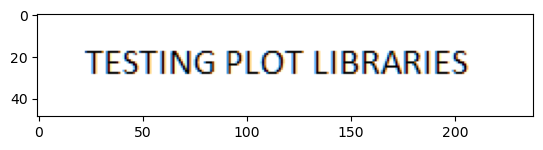

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
image = cv2.imread('C:/datasets/test.png')
plt.imshow(image)
plt.show()

In [2]:
import torch
import numpy as np
from tqdm.notebook import tqdm

# # check if CUDA is available
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 128

transforms = transforms.Compose([transforms.Resize((131,131)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    
# choose the training and test datasets
train_data = datasets.ImageFolder('D:/large_datasets/faces/', transform=transforms)

In [4]:
train_data

Dataset ImageFolder
    Number of datapoints: 7219
    Root location: D:/large_datasets/faces/
    StandardTransform
Transform: Compose(
               Resize(size=(131, 131), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

# specify the image classes
classes = train_data.classes; train_data.classes

['Humans']

### Visualize a Batch of Training Data

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [8]:
len(train_data.classes)

1

In [9]:
images.shape

(128, 3, 131, 131)

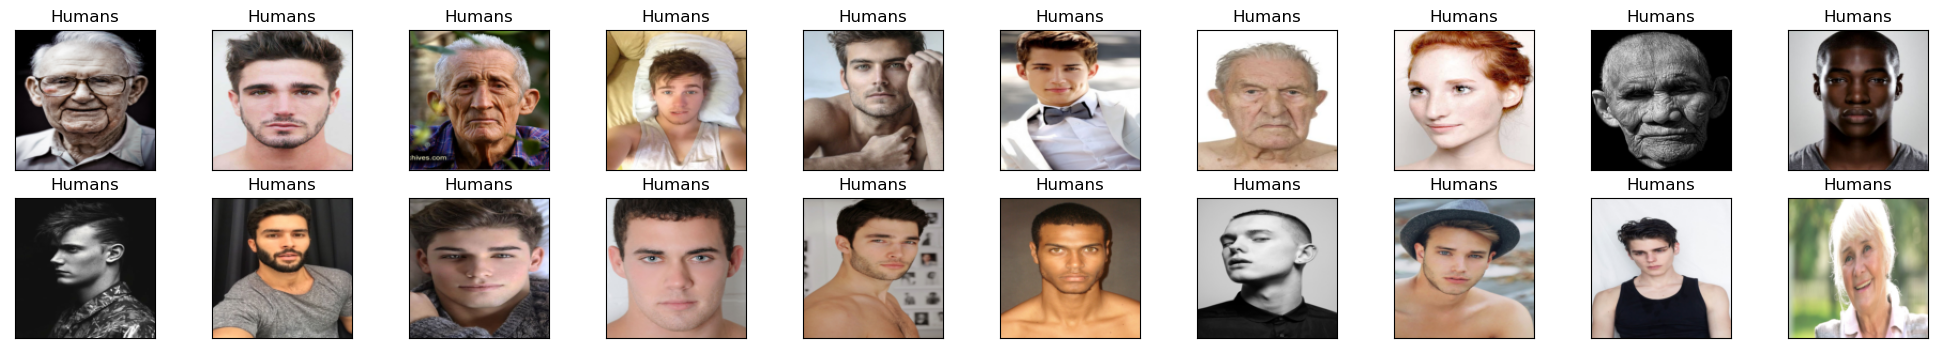

In [10]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 10 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [12]:
W = 28
F = 5
P = 2
S = 1
output_volume = ((W-F+2*P)/S+1 ); output_volume

28.0

In [64]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=2,padding=2),
            nn.Conv2d(64,96,kernel_size=3,stride=2,padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(96,128,kernel_size=3,stride=2,padding=2),
            nn.Conv2d(128,156,kernel_size=3,stride=2,padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(156,196,kernel_size=3,stride=2,padding=2),
            nn.Conv2d(196,224,kernel_size=3,stride=2,padding=2),
            nn.LeakyReLU()
        )

        #latent space
        self.embedding = nn.Sequential(
            nn.Linear(224 * 5 * 5, 2048),
            nn.LeakyReLU(),
            nn.Linear(2048,784)
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(196, 160,kernel_size=3,stride=2,padding=0),
            nn.ConvTranspose2d(160, 144,kernel_size=3,stride=2,padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(144, 128,kernel_size=3,stride=2,padding=2),
            nn.ConvTranspose2d(128, 96,kernel_size=3,stride=2,padding=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 64,kernel_size=3,stride=2,padding=2),
            nn.ConvTranspose2d(64, 3,kernel_size=3,stride=2,padding=2)
        )

    def forward(self, x):
        x = x.view(-1,3,131,131)
        encoded = self.encoder(x)
        x = encoded.view(-1,224 * 5 * 5) 
        embedding = self.embedding(x)
        x = embedding.view(-1,196,2,2)
#         x = x.view(-1,196,2,2)
        decoded = self.decoder(x)
        return decoded, embedding 

model = AutoEncoder().cuda()
# print(model)
print(model(torch.tensor(images[0:15]).cuda())[0].shape)

torch.Size([15, 3, 131, 131])


In [65]:
images[0:15].shape

(15, 3, 131, 131)

In [66]:
from torch.nn import MSELoss
import torch.optim as optim

In [67]:
criterion = MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 1 # you may increase this number to train a final model

train_loss_min = 5.030129 # track change in validation loss

for epoch in tqdm(range(1, n_epochs+1), desc="Epochs"):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    counter = 0
    model.train()
    for data, target in tqdm(train_loader):
        counter += 1
        data = data.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)[0].flatten()
        # calculate the batch loss
        loss = criterion(output, data.flatten())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/counter
    if train_loss > 100:
        print('gradient explosion')
        break
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))
    
    # save model if validation loss has decreased
    if train_loss <= train_loss_min:
        print('Similarity loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        train_loss_min,
        train_loss))
        torch.save(model.state_dict(), 'model_autoencoder_faces.pt')
        train_loss_min = train_loss

In [69]:
model.load_state_dict(torch.load('model_autoencoder_faces.pt'))

<All keys matched successfully>

In [70]:
img = torch.tensor(images).cuda()

In [71]:
vectors = []
for i in range(img.shape[0]):
    vectors.append(((model(img[i]))[1], i))

In [72]:
vectors[0][0].shape

torch.Size([1, 784])

In [73]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,stride=2,padding=2),
            nn.Conv2d(64,96,kernel_size=3,stride=2,padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(96,128,kernel_size=3,stride=2,padding=2),
            nn.Conv2d(128,156,kernel_size=3,stride=2,padding=2),
            nn.LeakyReLU(),
            nn.Conv2d(156,196,kernel_size=3,stride=2,padding=2),
            nn.Conv2d(196,224,kernel_size=3,stride=2,padding=2),
            nn.LeakyReLU()
        )

        #latent space
        self.embedding = nn.Sequential(
            nn.Linear(224 * 5 * 5, 2048),
            nn.LeakyReLU(),
            nn.Linear(2048,784)
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(196, 160,kernel_size=3,stride=2,padding=0),
            nn.ConvTranspose2d(160, 144,kernel_size=3,stride=2,padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(144, 128,kernel_size=3,stride=2,padding=2),
            nn.ConvTranspose2d(128, 96,kernel_size=3,stride=2,padding=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(96, 64,kernel_size=3,stride=2,padding=2),
            nn.ConvTranspose2d(64, 3,kernel_size=3,stride=2,padding=2)
        )

    def forward(self, x):
#         x = x.view(-1,3,131,131)
#         encoded = self.encoder(x)
#         x = encoded.view(-1,224 * 5 * 5) 
#         embedding = self.embedding(x)
#         x = embedding.view(-1,196,2,2)
        x = x.view(-1,196,2,2)
        decoded = self.decoder(x)
        return decoded

model = AutoEncoder().cuda()
# print(model)
# print(model(torch.tensor(images[0:15]).cuda())[0].shape)

In [74]:
model.load_state_dict(torch.load('model_autoencoder_faces.pt'))

<All keys matched successfully>

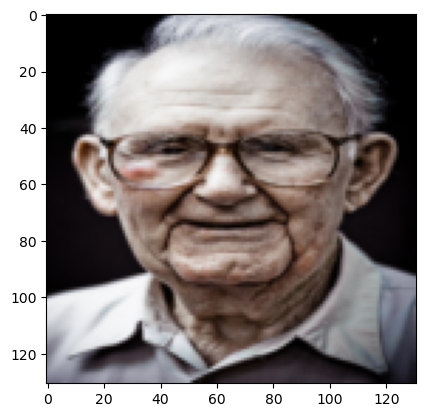

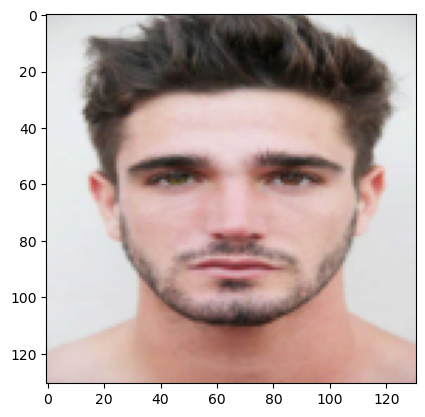

In [87]:
for i in range(2):
    imshow(img[i].view(3,131,131).cpu().detach().numpy())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


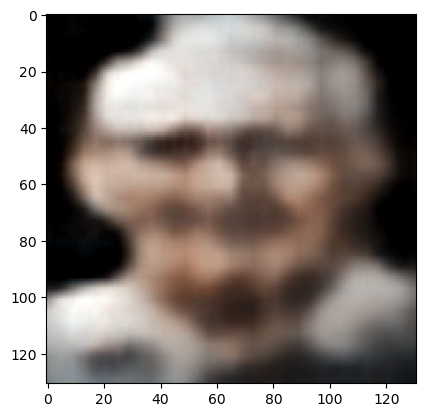

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


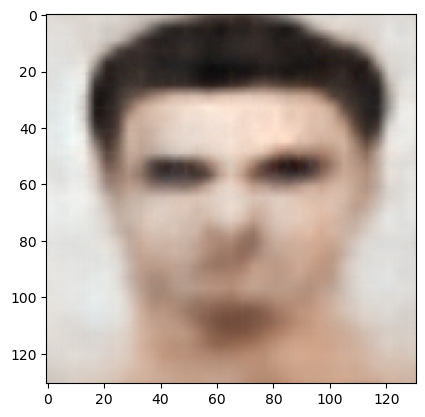

In [88]:
for i in range(2):
    imshow(model(vectors[i][0].cuda())[0].view(3,131,131).cpu().detach().numpy())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


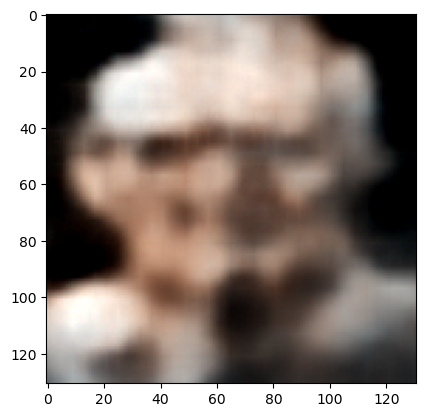

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


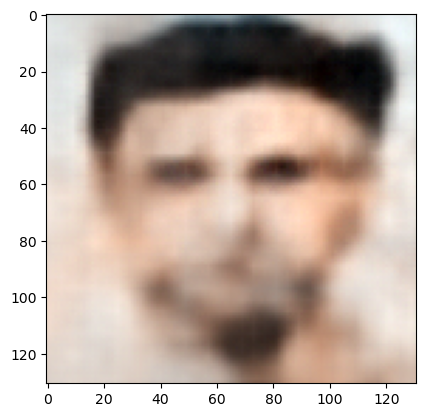

In [89]:
for i in range(2):
    transformed = vectors[i][0].cpu() + torch.tensor(np.random.randn(1,784) * np.random.randn(1,784) * 2.5 + 0.3).float()
    imshow(model(transformed.cuda())[0].view(3,131,131).cpu().detach().numpy())
    plt.show()